**NOTEBOOK FOR TESTING PERMANENT VARIABLES IN THE 2D EXAMPLE**

In [6]:
import numpy as np 
from numba import njit, prange
import matplotlib.pyplot as plt 

In [7]:
#Variables to test
#These variables should later on have permanent values, unliked temp and RH which may change values

attach_prob_divisor = 500 #This determines how the attach prob should be divided. Attach prob is proportional to Max M-value given conditions
#Max M-value corresponds to a certain coverage percentage. This should be divided by something to get attach probability. Minimum 100. 

decay_prob_multiplier  = 0.01 #decay_prob is inversely proportional to attach_prob, but must be multiplied by a number smaller than 1, lest all particles just decay. 
timesteps_per_day = 100 #We need to be able to talk about how many days have passed, to be able to compare it to experimental data. 
particle_boundary = 0.2 #After simulating many runs and averaging, some places will have values between 0 and 1. Some of these should be counted when considering mold surface coverage
# The particle boundary determines when these should be counted or discounted

In [ ]:
# Constants
GRID_SIZE = 100
RADIUS = GRID_SIZE//2
SEED = (GRID_SIZE // 2, GRID_SIZE // 2)  # Seed in the middle of the grid
DAYS = 128
TIMESTEPS = DAYS * timesteps_per_day
NUM_SIMS = 100
Temp = 30
RH = 97

In [ ]:
def attaching_prob(Temp, RH): 
    RH_crit = (-0.00267 * (Temp**3)) + (0.16*(Temp**2)) - (3.13*Temp) + 100
    if(RH < RH_crit):
        return 0
    M_max = 1+7*((RH_crit-RH)/(RH_crit-100))-2*((RH_crit - RH)/(RH_crit-100))**2 #The maximum M-value for the given temperature and relative humidity 
    #The above two formulas are from the paper "A mathematical model of mould growth on wooden material" by Hukka and Vitten 1999
    if(M_max < 0): 
        return 0

    area_covered = 133.6561 + (0.9444885 - 133.6561)/(1 + (M_max/4.951036)**5.67479)
    #The formula for translating M-value to surface coverage represented by that coverage, is retrieved by regression over the definition of M-value.
    #We use this as a stand-in for attachment probability. 
    #The regression is over the points (0,0), (1,1), (3,10), (4,30), (5,70), (6,100)
    #These are the points where the M-value is 0, 1, 3, 4, 5, 6, respectively as given by the table in "Development of an improved model for mould growth: Modelling"  
    #by Viitanen et al. 2008
    if area_covered > 100:
        return 1
    return area_covered/attach_prob_divisor

In [ ]:

def coverage_to_m_value(cov): 
    return 14.87349 + (-0.03030586 - 14.87349)/(1 + (cov/271.0396)**0.4418942)

In [ ]:

@njit(parallel=True)
def decay_grid(grid, DECAY_PROB):
    for i in prange(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i, j] == 1 and np.random.uniform() < DECAY_PROB:
                grid[i, j] = 0


ATTACH_PROB = attaching_prob(Temp, RH)
DECAY_PROB = (1 - ATTACH_PROB)*decay_prob_multiplier

In [ ]:
@njit(parallel = True) # This decorator tells Numba to compile this function using the JIT (just-in-time) compiler
def particle_loop(GRID_SIZE, grid, ATTACH_PROB, TIMESTEPS, DECAY_PROB):
    Reached_edge = False
    current_radius = 5 #spawns particles closer to where the seed is, to speed up the program. 
    
    for i in prange(TIMESTEPS):

        if i % 1000 == 0:
            decay_grid(grid, DECAY_PROB)

        if Reached_edge == False:
            angle = np.random.uniform(0, 2 * np.pi) # Random angle in radians
            particle = (int(GRID_SIZE/2 + current_radius * np.cos(angle)), int(GRID_SIZE/2 + current_radius * np.sin(angle)))
        else: 
            particle = (np.random.randint(0, GRID_SIZE), np.random.randint(0, GRID_SIZE))
        while True:
            # Create the particle starting from a random point on the circle
            #use angle and spawn point of seed (which is the middle of the grid) ...
            # ... to calculate the x and y coordinates of a new particle. Cast it to int also. 

            dist_to_seed = np.sqrt((particle[0] - GRID_SIZE/2) ** 2 + (particle[1] - GRID_SIZE/2) ** 2)
            
            # Check if particle is out of bounds (ensure it's within grid size)
            if Reached_edge == False and dist_to_seed >= current_radius + 5:
                break
            elif Reached_edge == True and (particle[0] < 0  or particle[1] < 0 or particle[0] >= GRID_SIZE or particle[1] >= GRID_SIZE ):
                break

            # Check if the particle can attach to any adjacent grid cell (touches the cluster)
            if (grid[particle[0] + 1, particle[1]] == 1 or
                grid[particle[0] - 1, particle[1]] == 1 or
                grid[particle[0], particle[1] + 1] == 1 or
                grid[particle[0], particle[1] - 1] == 1):


                if np.random.uniform() < ATTACH_PROB:
                    grid[particle[0], particle[1]] = 1  # Attach particle to the grid
                    if dist_to_seed >= current_radius-1 and Reached_edge == False:
                        current_radius += 5
                        if current_radius >= RADIUS:
                            Reached_edge = True
                
                break  # Once the particle reaches a neighbor, it is either attached or killed. Either way the loop breaks
                

            # Move the particle randomly until we pass the loop manually
            move = np.random.randint(0, 4)  # Randomly select one of four directions
            if move == 0:
                particle = (particle[0], particle[1] + 1)  # Move up
            elif move == 1:
                particle = (particle[0] + 1, particle[1])  # Move right
            elif move == 2:
                particle = (particle[0], particle[1] - 1)  # Move down
            elif move == 3:
                particle = (particle[0] - 1, particle[1])  # Move left
        

In [ ]:
@njit(parallel=True)
def monte_carlo(GRID_SIZE, ATTACH_PROB, TIMESTEPS, NUM_SIMS, DECAY_PROB):
    print("attach_prob:" , ATTACH_PROB)
    print("decay_prob: ", DECAY_PROB)
    aggr_grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1))
    for _ in prange(NUM_SIMS):
        # Initialize grid (plus 1 to account for 0-index)
        grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1))
        grid[SEED[0], SEED[1]] = 1  # Set seed point as part of cluster
        particle_loop(GRID_SIZE, grid, ATTACH_PROB, TIMESTEPS, DECAY_PROB)
        aggr_grid += grid

    aggr_grid = aggr_grid/NUM_SIMS
    mold_grid = aggr_grid.copy()

    for i in prange(mold_grid.shape[0]): 
        for j in prange(mold_grid.shape[1]): 
            if mold_grid[i][j] > particle_boundary: 
                mold_grid[i][j]= 1


    
    mold_cov = np.sum(mold_grid)/(mold_grid.shape[0]*mold_grid.shape[1]) * 100
    return aggr_grid, mold_cov

attach_prob: 0.1763731082643741
decay_prob:  0.008236268917356258
Average mold coverage:  10.860307812959437 %
M-value:  2.867060679774708
Temperature:  30
Relative Humidity:  97


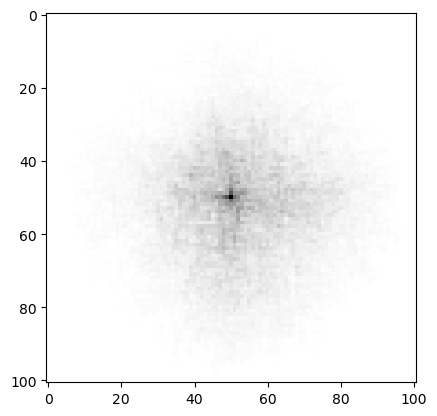

In [8]:
final_grid, mold_cov = monte_carlo(GRID_SIZE, ATTACH_PROB, TIMESTEPS, NUM_SIMS, DECAY_PROB)
print("Average mold coverage: ", mold_cov , "%")
print("M-value: ", coverage_to_m_value(mold_cov))
print("Temperature: "   , Temp)
print("Relative Humidity: " , RH)
# Plot the result
plt.imshow(final_grid, cmap='Greys', interpolation='nearest')
plt.show()